# Model

## require pacakges

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils


## Hyperparameters & Labels

In [6]:
# 하이퍼파라미터 설정 
latent_dim = 100
num_classes = 10
img_size = 32
batch_size = 64
num_epochs = 300 # 총 학습시킬 Epochs 설정 : 나중에 argparse로 관리할 값
n_critic = 5
clip_value = 0.01
lr = 0.00005
path = 'weight/GAN_epoch_100.pth'  # 가중치 경로 (파일 확장자는 제외), 학습시킬 epoch 위치


# CIFAR-10 라벨에 대한 영어 텍스트 매핑
label_to_english = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

## Weight In/Out Module

In [7]:
# 모델 가중치 저장 함수 (epoch을 파일명에 포함시킴)
def save_model_weights(generator, critic, epoch, path='weight/'):
    """
    모델의 가중치를 저장하는 함수. 파일명에 epoch 번호를 추가.
    """
    # epoch을 포함한 파일명 생성
    epoch_path = path+f"GAN_epoch_{epoch}.pth"
    
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'critic_state_dict': critic.state_dict(),
    }, epoch_path)
    
    return epoch_path
    print(f"모델 가중치를 {epoch_path}에 저장했습니다.")



# 모델 가중치 불러오기 함수
def load_model_weights(generator, critic, path):
    """
    저장된 모델의 가중치를 불러오는 함수.
    return으로 epoch을 줘야, 이어서 학습하면서 epoch을 기록할 수 있음
    """
    checkpoint = torch.load(path)
    epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['generator_state_dict'])
    critic.load_state_dict(checkpoint['critic_state_dict'])
    print(f"모델 가중치를 {path}에서 불러왔습니다. 마지막 epoch: {epoch}")
    return epoch

## Visualization Module

In [8]:

def show_noise_and_generated_images(generator, num_classes=10, latent_dim=100):
    """
    CIFAR-10의 10개 라벨에 대해 노이즈 벡터와 생성된 이미지를 함께 표시합니다.
    :param generator: 학습된 Generator 모델
    :param num_classes: CIFAR-10의 클래스 개수 (10)
    :param latent_dim: 노이즈 벡터의 차원
    """
    generator.eval()
    with torch.no_grad():
        # 10개 라벨 각각에 대해 이미지 생성
        z = torch.randn(10, latent_dim).to(device)  # 10개 노이즈 벡터 생성
        labels = torch.arange(0, num_classes).to(device)  # 0부터 9까지 라벨 생성
        
        # 노이즈 벡터와 라벨 시각화
        fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2x5 배열로 이미지 배치
        axes = axes.flatten()

        for i in range(num_classes):
            # 노이즈 벡터
            noise_img = z[i].cpu().numpy().reshape(10, 10)  # 노이즈 벡터를 10x10 배열로 변환하여 표시
            axes[i].imshow(noise_img, cmap='gray')
            axes[i].set_title(f"Noise + Label: {label_to_english[labels[i].item()]}\nNumber: {labels[i].item()}")
            axes[i].axis("off")
        
        plt.tight_layout()
        plt.show()

        # 생성된 이미지
        gen_imgs = generator(z, labels)
        gen_imgs = (gen_imgs * 0.5) + 0.5  # [-1, 1]에서 [0, 1]로 변환

        # 생성된 이미지 시각화
        fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2x5 배열로 이미지 배치
        axes = axes.flatten()

        for i in range(num_classes):
            # 생성된 이미지
            img = gen_imgs[i].cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC 변환
            label_english = label_to_english[labels[i].item()]  # 영어 라벨 추출
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {label_english}\nNumber: {labels[i].item()}")  # 영어 라벨과 숫자 라벨 표시
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

## Train Module

In [10]:
# Generator 클래스 정의
class Generator(nn.Module):
    """
    Generator는 조건부 GAN에서 조건을 받아 이미지를 생성하는 모델입니다.
    랜덤 노이즈와 레이블을 입력받아 가짜 이미지를 생성합니다.
    """
    def __init__(self, latent_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)  # 레이블을 임베딩하여 조건으로 사용
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size**2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 업샘플링하여 이미지를 점차적으로 확대
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()  # 출력 이미지는 -1과 1 사이로 정규화
        )

    def forward(self, noise, labels):
        """
        랜덤 노이즈와 레이블을 입력받아 이미지를 생성합니다.
        """
        label_input = self.label_embed(labels)  # 레이블 임베딩
        gen_input = torch.cat((noise, label_input), -1)  # 노이즈와 레이블을 결합
        out = self.l1(gen_input)  # 첫 번째 레이어를 통과
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # 이미지 크기로 reshape
        img = self.conv_blocks(out)  # 업샘플링 및 합성곱 블록을 통과
        return img

# Critic 클래스 정의
class Critic(nn.Module):
    """
    Critic은 WGAN의 목적 함수에서 중요한 역할을 하며, 생성된 이미지의 진위 여부를 평가합니다.
    이 모델은 조건부 GAN에서 레이블을 포함하여 이미지를 평가합니다.
    """
    def __init__(self, num_classes, img_size):
        super(Critic, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)  # 레이블 임베딩
        self.model = nn.Sequential(
            nn.Conv2d(3 + num_classes, 64, 4, stride=2, padding=1),  # 입력 이미지와 레이블 결합 후 합성곱
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, stride=1, padding=0)  # 최종 출력은 스칼라 값
        )

    def forward(self, img, labels):
        """
        이미지를 입력받고, 레이블을 결합하여 이미지를 평가합니다.
        """
        label_input = self.label_embed(labels).unsqueeze(2).unsqueeze(3)  # 레이블 임베딩
        label_input = label_input.expand(img.size(0), label_input.size(1), img.size(2), img.size(3))  # 이미지 크기에 맞게 확장
        d_in = torch.cat((img, label_input), 1)  # 이미지와 레이블을 채널 차원으로 결합
        validity = self.model(d_in)  # 평가 모델 통과
        return validity.view(-1)  # 1D 벡터로 변환하여 반환

# 데이터 로딩 및 전처리 모듈
def load_data(batch_size=64):
    """
    CIFAR-10 데이터셋을 로드하고, 데이터 전처리 및 DataLoader를 설정합니다.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]로 정규화
    ])
    cifar10 = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)
    return dataloader

import os
import torch



# 이미지 생성 및 결과 시각화
def show_generated_images(generator, latent_dim, num_classes, device):
    """
    학습된 Generator를 사용하여 이미지를 생성하고 시각화합니다.
    """
    z = torch.randn(9, latent_dim).to(device)  # 랜덤 노이즈 생성
    labels = torch.randint(0, num_classes, (9,)).to(device)  # 랜덤 레이블 생성
    with torch.no_grad():
        gen_imgs = generator(z, labels)
        gen_imgs = (gen_imgs * 0.5) + 0.5  # [-1, 1]에서 [0, 1]로 변환
        grid = vutils.make_grid(gen_imgs, nrow=3)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title("Generated Images")
        plt.axis("off")
        plt.show()

def train_model(generator, critic, dataloader, optimizer_G, optimizer_C, num_epochs, n_critic, clip_value, device, start_epoch=1):
    """
    Generator와 Critic을 학습시키는 함수입니다.
    - n_critic: Critic을 몇 번 학습시킬지 결정하는 값
    - clip_value: WGAN에서 가중치를 클리핑할 때 사용하는 값
    - start_epoch: 학습을 시작할 epoch (가중치 파일이 있을 때만 적용)
    """
    # 학습을 시작할 epoch부터 시작
    for epoch in range(start_epoch, num_epochs + 1):
        for i, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Critic 학습
            optimizer_C.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)  # 노이즈 생성
            fake_imgs = generator(z, labels).detach()  # 생성된 가짜 이미지

            real_loss = critic(imgs, labels).mean()  # 진짜 이미지에 대한 평가
            fake_loss = critic(fake_imgs, labels).mean()  # 가짜 이미지에 대한 평가
            critic_loss = -(real_loss - fake_loss)  # WGAN에서의 Critic 손실 계산
            critic_loss.backward()
            optimizer_C.step()

            # 가중치 클리핑
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)
            
            # Generator 학습 (n_critic 주기마다)
            if i % n_critic == 0:
                optimizer_G.zero_grad()
                gen_imgs = generator(z, labels)
                generator_loss = -critic(gen_imgs, labels).mean()  # Generator 손실
                generator_loss.backward()
                optimizer_G.step()

        print(f"[Epoch {epoch}/{num_epochs}] [C Loss: {critic_loss.item():.4f}] [G Loss: {generator_loss.item():.4f}]")

        # 10 epoch마다 모델 가중치 저장
        if epoch % 10 == 0:
            epoch_path = save_model_weights(generator, critic, epoch)
            print(f"모델 가중치를 {epoch_path}에 저장했습니다.")
            
            # 학습된 모델을 통해 노이즈 벡터와 생성된 이미지 시각화
            show_noise_and_generated_images(generator)


## Training

Files already downloaded and verified


/tmp/ipykernel_72544/3529374488.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


모델 가중치를 weight/GAN_epoch_100.pth에서 불러왔습니다. 마지막 epoch: 100
가중치 파일을 불러왔습니다. 101번째 epoch부터 학습을 시작합니다.
[Epoch 101/300] [C Loss: -0.0822] [G Loss: 0.0263]
[Epoch 102/300] [C Loss: -0.0538] [G Loss: 0.0428]
[Epoch 103/300] [C Loss: -0.0450] [G Loss: 0.0380]
[Epoch 104/300] [C Loss: -0.0489] [G Loss: 0.0258]
[Epoch 105/300] [C Loss: -0.0364] [G Loss: 0.0318]
[Epoch 106/300] [C Loss: -0.0527] [G Loss: 0.0398]
[Epoch 107/300] [C Loss: -0.0125] [G Loss: 0.0316]
[Epoch 108/300] [C Loss: -0.0692] [G Loss: 0.0399]
[Epoch 109/300] [C Loss: -0.1079] [G Loss: 0.0412]
[Epoch 110/300] [C Loss: -0.0548] [G Loss: 0.0346]
모델 가중치를 weight/GAN_epoch_110.pth에 저장했습니다.


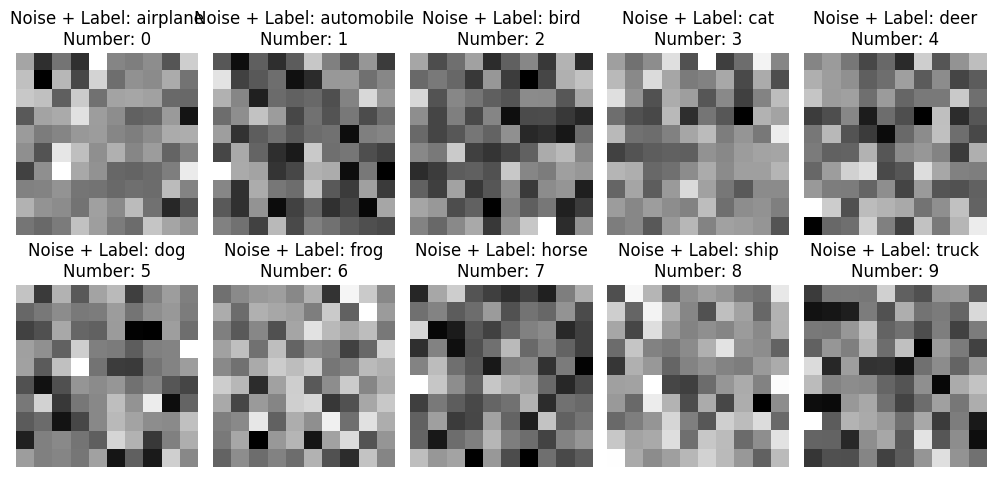

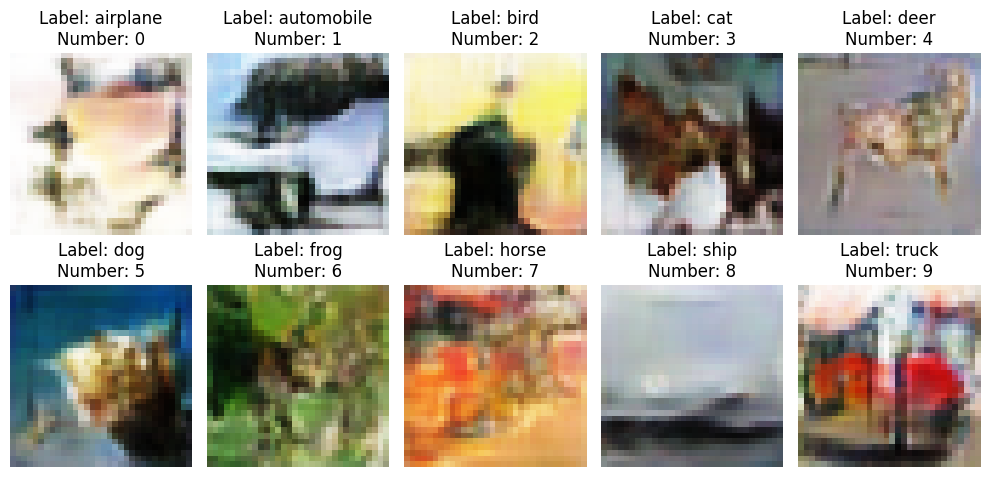

[Epoch 111/300] [C Loss: -0.0697] [G Loss: 0.0607]
[Epoch 112/300] [C Loss: -0.0496] [G Loss: 0.0405]
[Epoch 113/300] [C Loss: -0.0575] [G Loss: 0.0385]
[Epoch 114/300] [C Loss: -0.0729] [G Loss: 0.0358]
[Epoch 115/300] [C Loss: -0.0510] [G Loss: 0.0324]
[Epoch 116/300] [C Loss: -0.0338] [G Loss: 0.0505]
[Epoch 117/300] [C Loss: -0.0356] [G Loss: 0.0281]
[Epoch 118/300] [C Loss: -0.0515] [G Loss: 0.0279]
[Epoch 119/300] [C Loss: -0.0137] [G Loss: 0.0394]
[Epoch 120/300] [C Loss: -0.1044] [G Loss: 0.0410]
모델 가중치를 weight/GAN_epoch_120.pth에 저장했습니다.


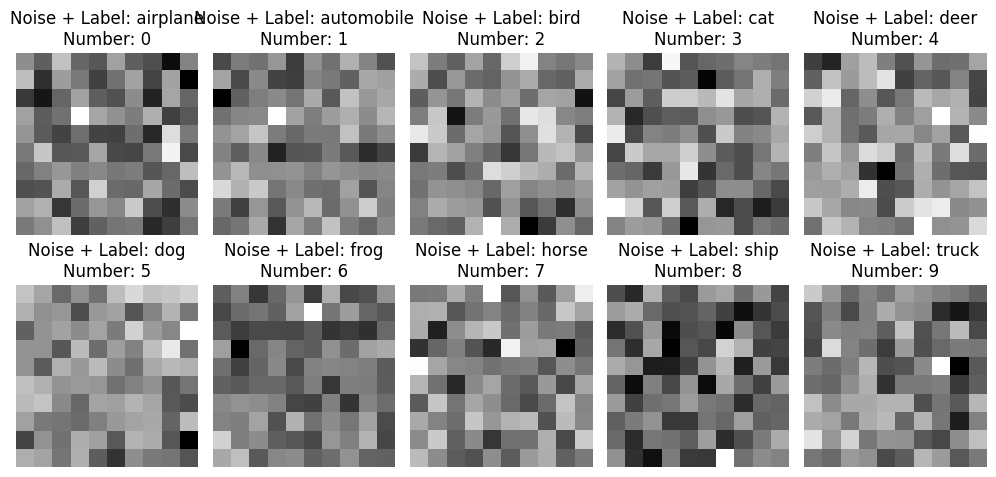

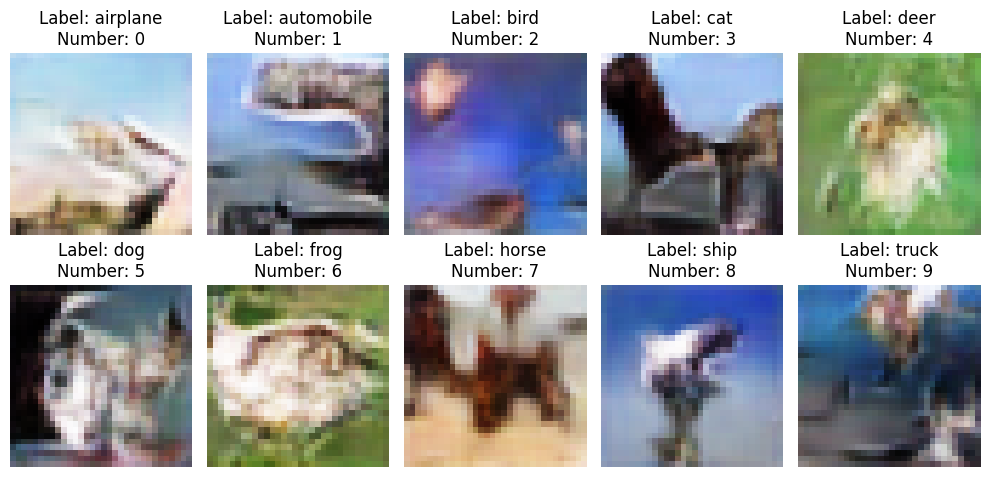

[Epoch 121/300] [C Loss: -0.0329] [G Loss: 0.0284]
[Epoch 122/300] [C Loss: -0.0416] [G Loss: 0.0119]
[Epoch 123/300] [C Loss: -0.0474] [G Loss: 0.0344]
[Epoch 124/300] [C Loss: -0.0783] [G Loss: 0.0594]
[Epoch 125/300] [C Loss: -0.0352] [G Loss: 0.0411]
[Epoch 126/300] [C Loss: -0.1140] [G Loss: 0.0566]
[Epoch 127/300] [C Loss: -0.0762] [G Loss: 0.0364]
[Epoch 128/300] [C Loss: -0.0405] [G Loss: 0.0495]
[Epoch 129/300] [C Loss: -0.0530] [G Loss: 0.0233]
[Epoch 130/300] [C Loss: -0.0356] [G Loss: -0.0041]
모델 가중치를 weight/GAN_epoch_130.pth에 저장했습니다.


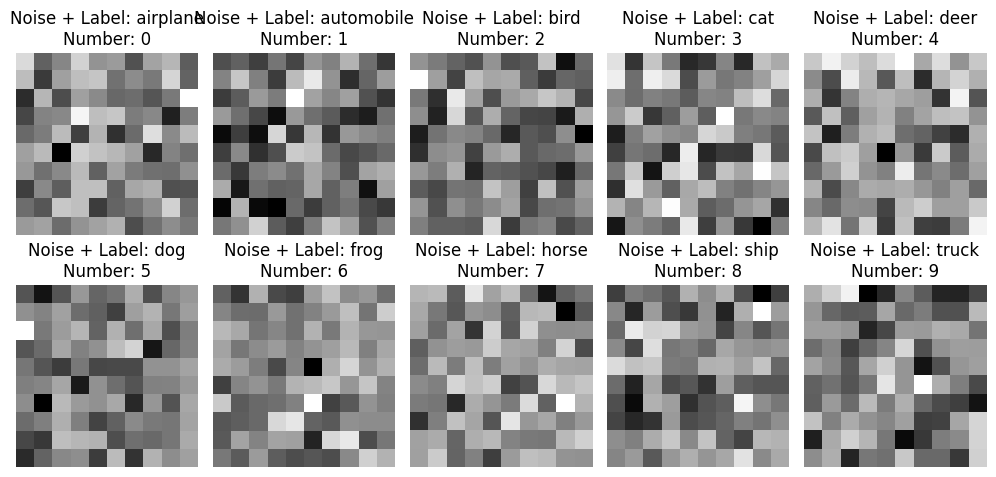

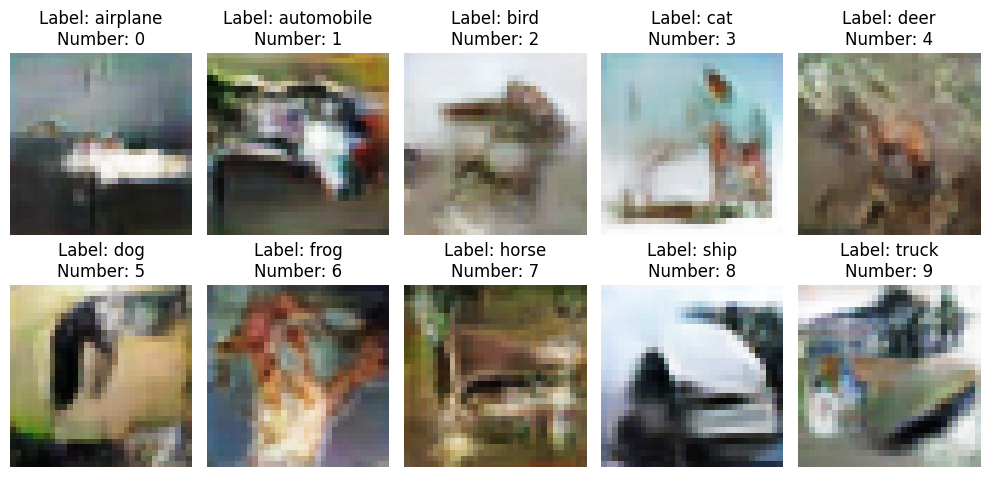

[Epoch 131/300] [C Loss: -0.0655] [G Loss: 0.0428]
[Epoch 132/300] [C Loss: -0.0368] [G Loss: 0.0395]
[Epoch 133/300] [C Loss: -0.0555] [G Loss: 0.0478]
[Epoch 134/300] [C Loss: -0.0429] [G Loss: 0.0279]
[Epoch 135/300] [C Loss: 0.0049] [G Loss: 0.0169]
[Epoch 136/300] [C Loss: -0.0719] [G Loss: 0.0354]
[Epoch 137/300] [C Loss: -0.0459] [G Loss: 0.0344]
[Epoch 138/300] [C Loss: -0.0175] [G Loss: 0.0460]
[Epoch 139/300] [C Loss: -0.0761] [G Loss: 0.0174]
[Epoch 140/300] [C Loss: -0.0050] [G Loss: -0.0119]
모델 가중치를 weight/GAN_epoch_140.pth에 저장했습니다.


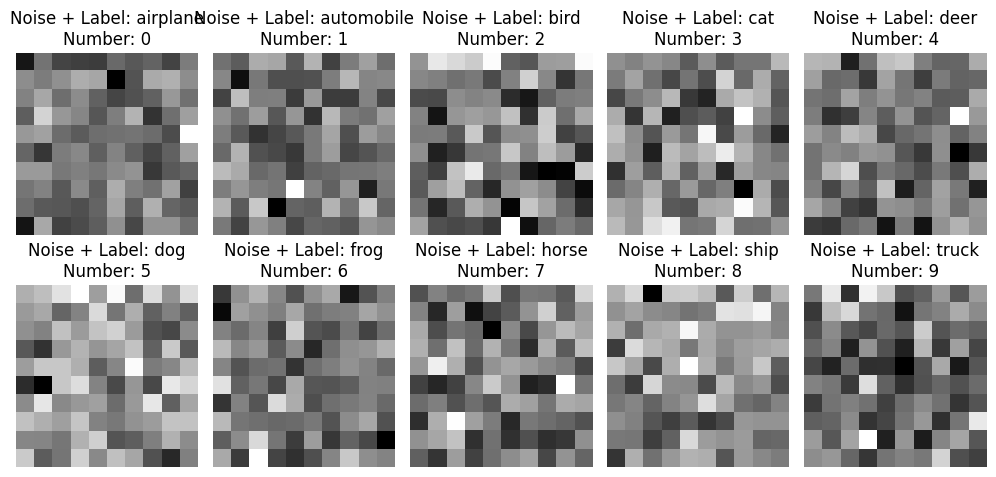

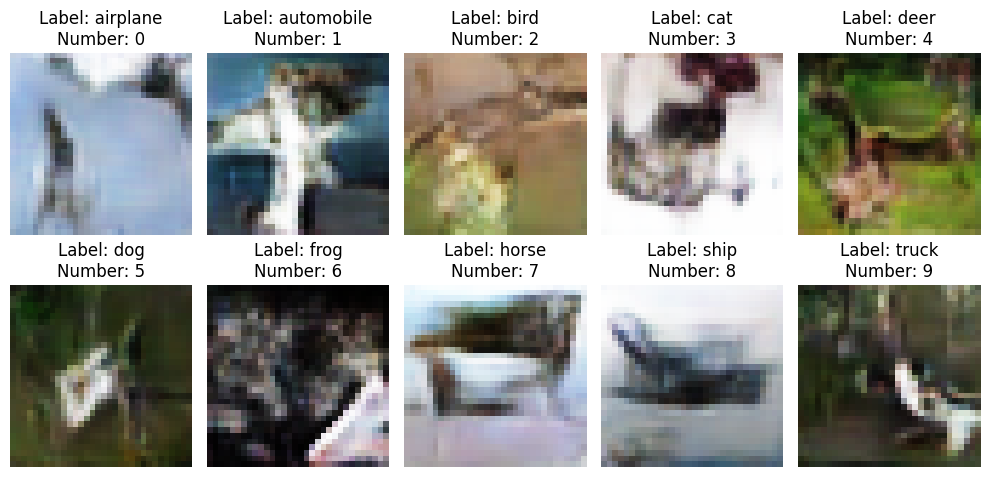

[Epoch 141/300] [C Loss: -0.0386] [G Loss: 0.0354]
[Epoch 142/300] [C Loss: -0.0374] [G Loss: 0.0350]
[Epoch 143/300] [C Loss: -0.0460] [G Loss: 0.0308]
[Epoch 144/300] [C Loss: -0.0299] [G Loss: 0.0547]
[Epoch 145/300] [C Loss: -0.0234] [G Loss: 0.0137]
[Epoch 146/300] [C Loss: -0.0328] [G Loss: 0.0400]
[Epoch 147/300] [C Loss: -0.0288] [G Loss: 0.0259]
[Epoch 148/300] [C Loss: -0.0616] [G Loss: 0.0396]
[Epoch 149/300] [C Loss: -0.0272] [G Loss: 0.0196]
[Epoch 150/300] [C Loss: -0.0782] [G Loss: 0.0726]
모델 가중치를 weight/GAN_epoch_150.pth에 저장했습니다.


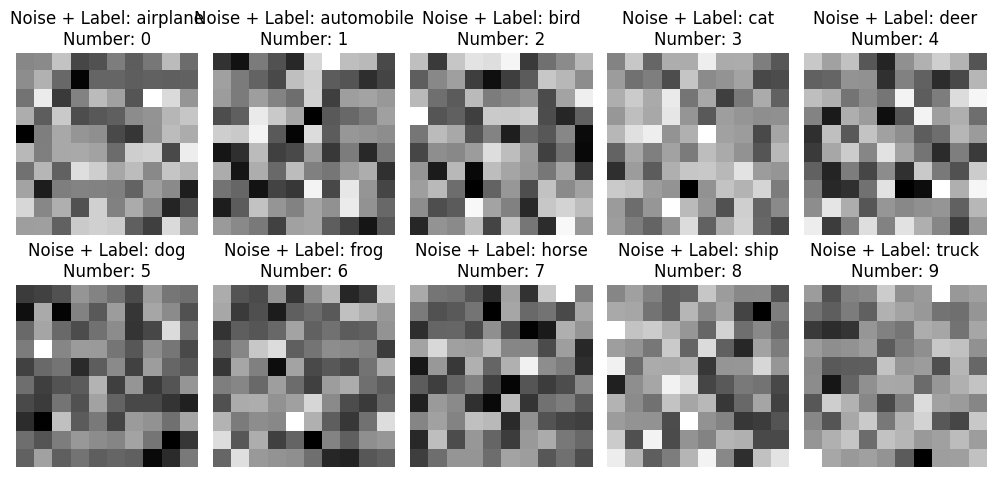

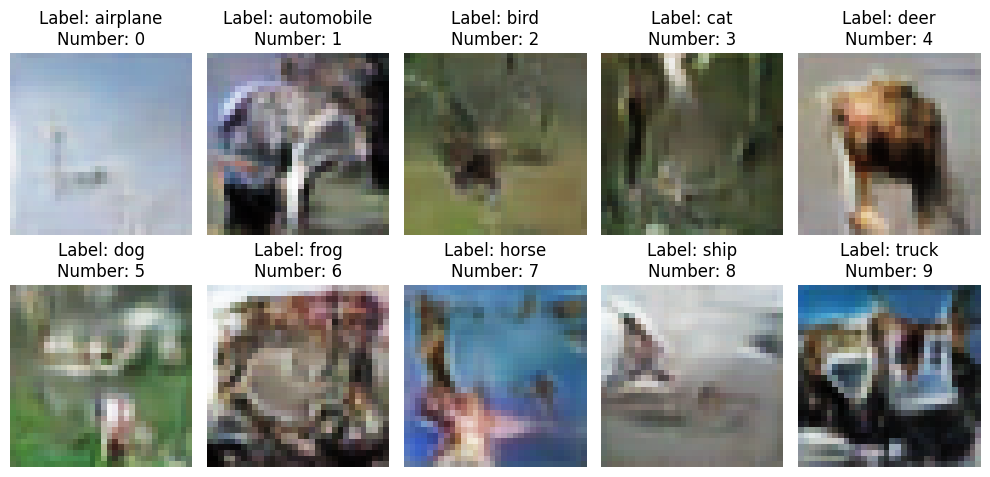

[Epoch 151/300] [C Loss: -0.0259] [G Loss: 0.0499]
[Epoch 152/300] [C Loss: -0.0557] [G Loss: 0.0244]
[Epoch 153/300] [C Loss: -0.0311] [G Loss: 0.0002]
[Epoch 154/300] [C Loss: -0.0432] [G Loss: 0.0046]
[Epoch 155/300] [C Loss: -0.0814] [G Loss: 0.0509]
[Epoch 156/300] [C Loss: -0.0645] [G Loss: 0.0236]
[Epoch 157/300] [C Loss: -0.0562] [G Loss: 0.0182]
[Epoch 158/300] [C Loss: -0.0136] [G Loss: 0.0227]
[Epoch 159/300] [C Loss: -0.0217] [G Loss: 0.0382]
[Epoch 160/300] [C Loss: -0.0392] [G Loss: 0.0588]
모델 가중치를 weight/GAN_epoch_160.pth에 저장했습니다.


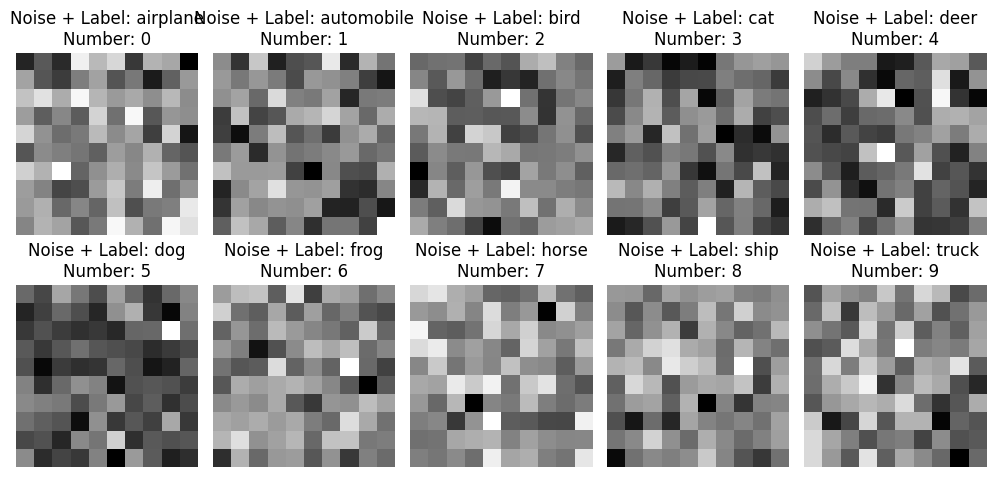

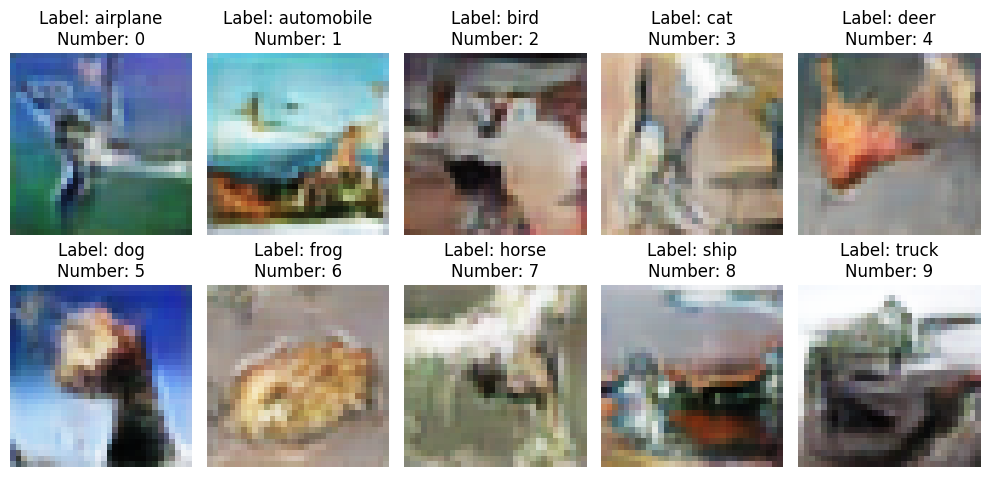

[Epoch 161/300] [C Loss: -0.0410] [G Loss: 0.0467]
[Epoch 162/300] [C Loss: -0.0121] [G Loss: 0.0366]
[Epoch 163/300] [C Loss: -0.0276] [G Loss: 0.0240]
[Epoch 164/300] [C Loss: -0.0126] [G Loss: 0.0239]
[Epoch 165/300] [C Loss: -0.0355] [G Loss: 0.0079]
[Epoch 166/300] [C Loss: -0.0239] [G Loss: 0.0269]
[Epoch 167/300] [C Loss: -0.0366] [G Loss: 0.0076]
[Epoch 168/300] [C Loss: -0.0238] [G Loss: 0.0550]
[Epoch 169/300] [C Loss: -0.0548] [G Loss: 0.0234]
[Epoch 170/300] [C Loss: -0.0675] [G Loss: 0.0087]
모델 가중치를 weight/GAN_epoch_170.pth에 저장했습니다.


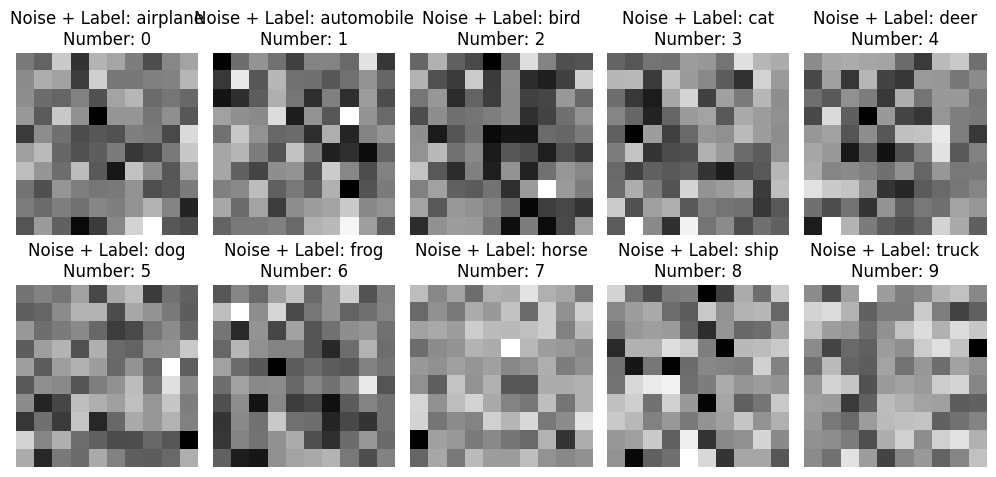

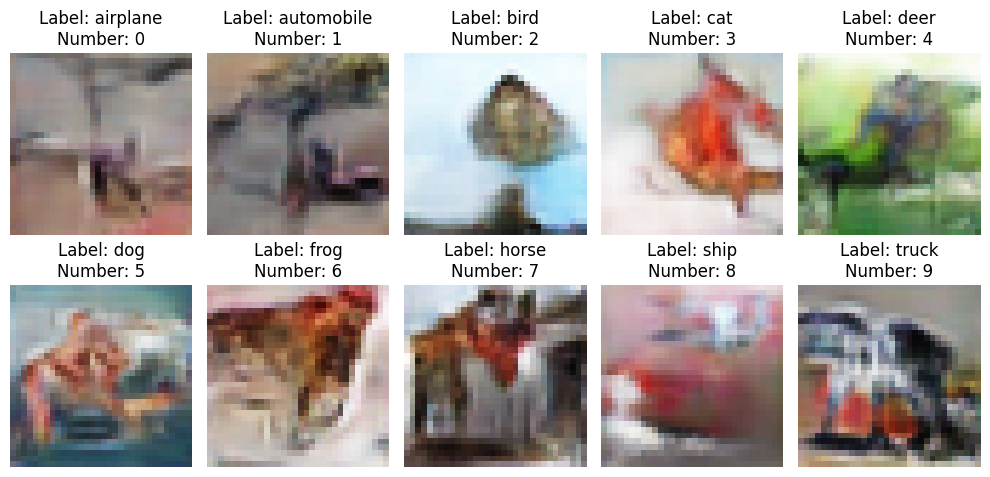

[Epoch 171/300] [C Loss: -0.0240] [G Loss: 0.0046]
[Epoch 172/300] [C Loss: 0.0252] [G Loss: 0.0429]
[Epoch 173/300] [C Loss: -0.0242] [G Loss: 0.0295]
[Epoch 174/300] [C Loss: -0.0507] [G Loss: 0.0278]
[Epoch 175/300] [C Loss: -0.0426] [G Loss: 0.0144]
[Epoch 176/300] [C Loss: -0.0377] [G Loss: 0.0475]
[Epoch 177/300] [C Loss: -0.0496] [G Loss: 0.0198]
[Epoch 178/300] [C Loss: -0.0215] [G Loss: 0.0453]
[Epoch 179/300] [C Loss: -0.0157] [G Loss: 0.0424]
[Epoch 180/300] [C Loss: -0.0073] [G Loss: 0.0367]
모델 가중치를 weight/GAN_epoch_180.pth에 저장했습니다.


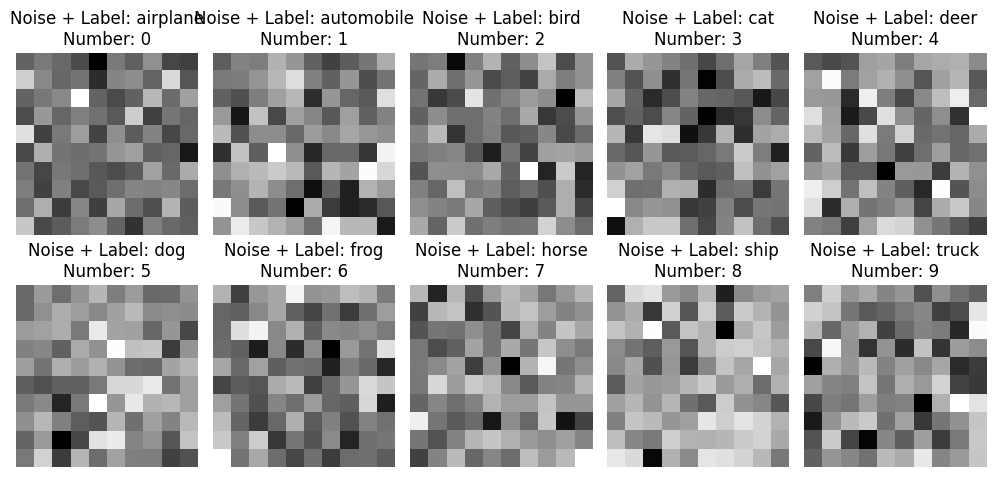

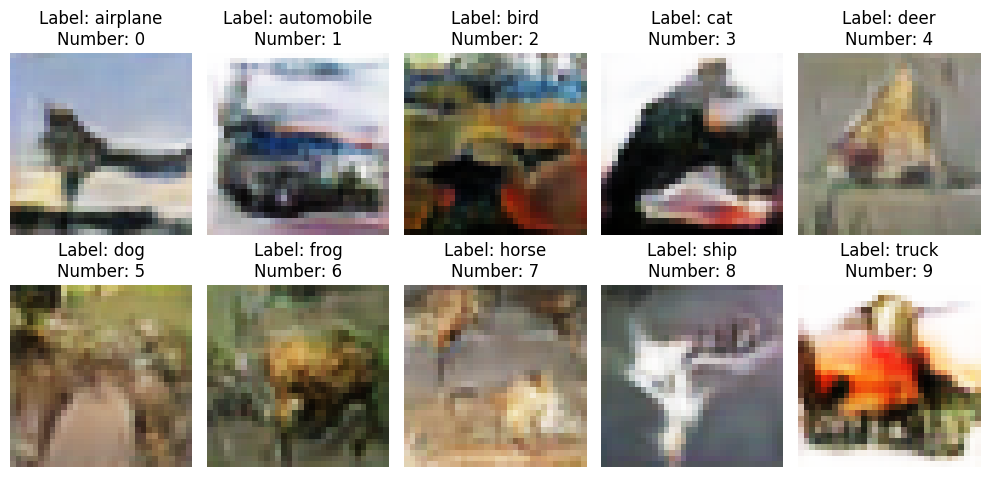

[Epoch 181/300] [C Loss: -0.0119] [G Loss: 0.0119]
[Epoch 182/300] [C Loss: -0.0226] [G Loss: 0.0169]
[Epoch 183/300] [C Loss: -0.0506] [G Loss: 0.0440]
[Epoch 184/300] [C Loss: -0.0083] [G Loss: 0.0248]
[Epoch 185/300] [C Loss: -0.0558] [G Loss: 0.0229]
[Epoch 186/300] [C Loss: -0.0348] [G Loss: 0.0354]
[Epoch 187/300] [C Loss: -0.0472] [G Loss: 0.0256]
[Epoch 188/300] [C Loss: -0.0446] [G Loss: 0.0393]
[Epoch 189/300] [C Loss: -0.0290] [G Loss: 0.0369]
[Epoch 190/300] [C Loss: -0.0529] [G Loss: 0.0142]
모델 가중치를 weight/GAN_epoch_190.pth에 저장했습니다.


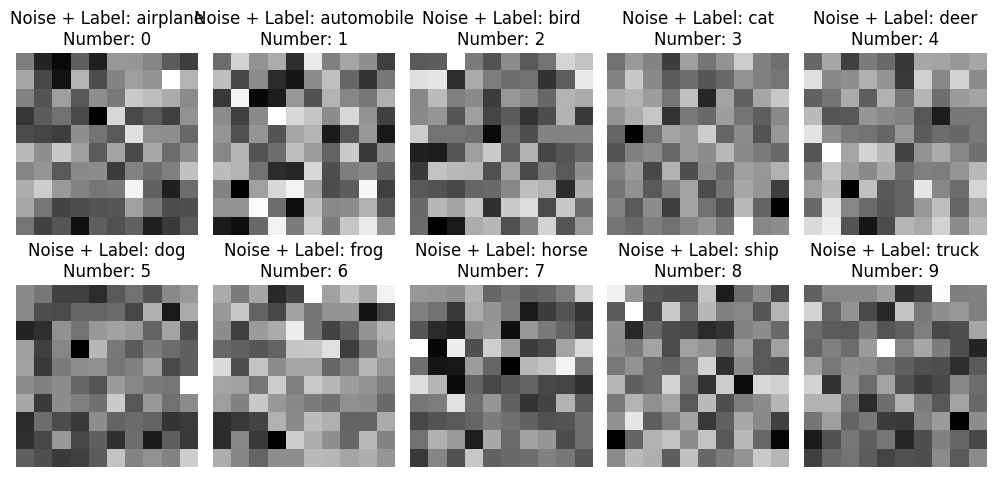

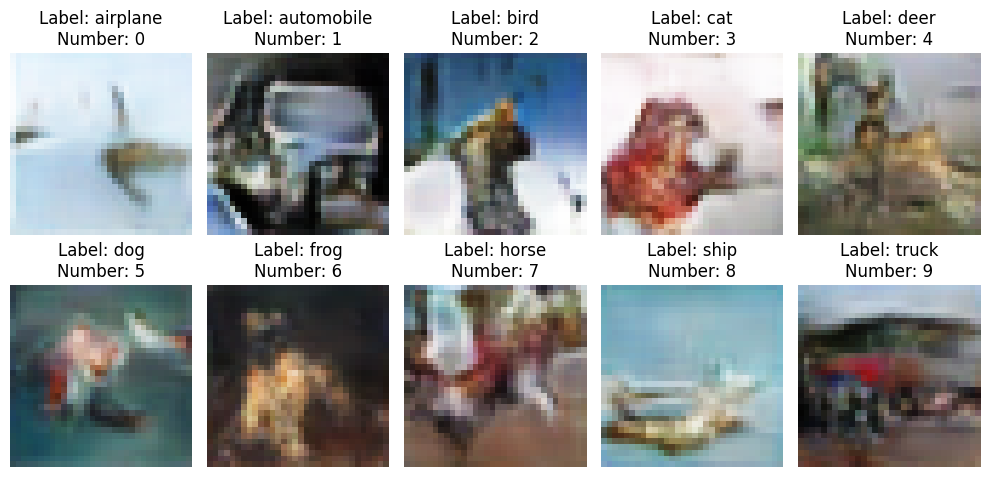

[Epoch 191/300] [C Loss: -0.0235] [G Loss: 0.0041]
[Epoch 192/300] [C Loss: -0.0914] [G Loss: 0.0123]
[Epoch 193/300] [C Loss: 0.0099] [G Loss: 0.0072]
[Epoch 194/300] [C Loss: 0.0029] [G Loss: 0.0126]
[Epoch 195/300] [C Loss: -0.0250] [G Loss: 0.0104]
[Epoch 196/300] [C Loss: -0.0620] [G Loss: 0.0258]
[Epoch 197/300] [C Loss: -0.0162] [G Loss: 0.0141]
[Epoch 198/300] [C Loss: -0.0202] [G Loss: 0.0243]
[Epoch 199/300] [C Loss: -0.0420] [G Loss: 0.0375]
[Epoch 200/300] [C Loss: -0.0509] [G Loss: 0.0192]
모델 가중치를 weight/GAN_epoch_200.pth에 저장했습니다.


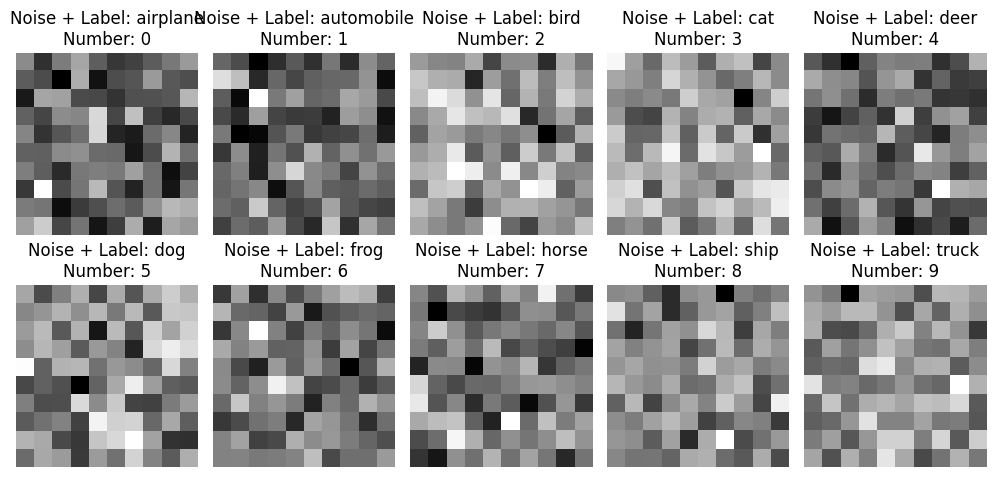

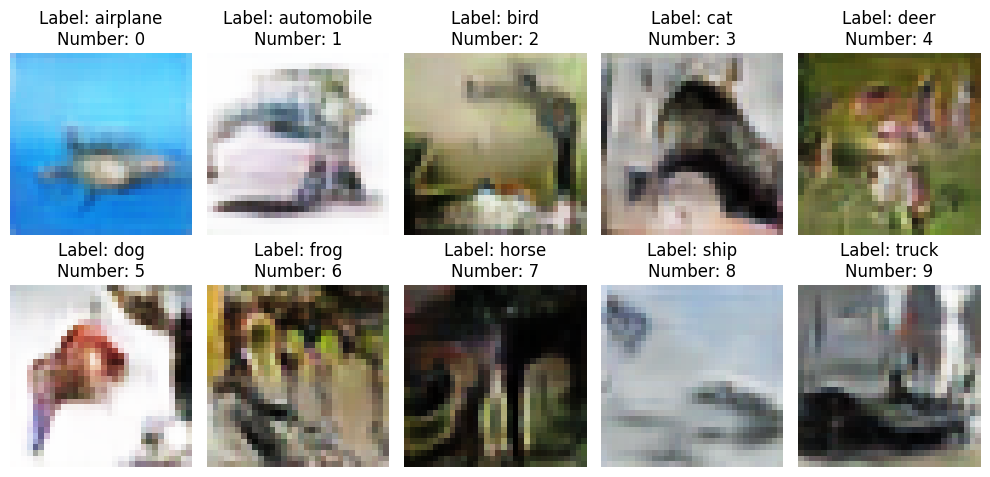

[Epoch 201/300] [C Loss: -0.0238] [G Loss: 0.0183]
[Epoch 202/300] [C Loss: -0.0399] [G Loss: -0.0093]
[Epoch 203/300] [C Loss: 0.0088] [G Loss: 0.0149]
[Epoch 204/300] [C Loss: -0.0329] [G Loss: 0.0199]
[Epoch 205/300] [C Loss: -0.0209] [G Loss: 0.0692]
[Epoch 206/300] [C Loss: -0.0305] [G Loss: -0.0013]
[Epoch 207/300] [C Loss: -0.0416] [G Loss: 0.0218]
[Epoch 208/300] [C Loss: 0.0176] [G Loss: 0.0132]
[Epoch 209/300] [C Loss: -0.0485] [G Loss: 0.0404]
[Epoch 210/300] [C Loss: 0.0246] [G Loss: 0.0170]
모델 가중치를 weight/GAN_epoch_210.pth에 저장했습니다.


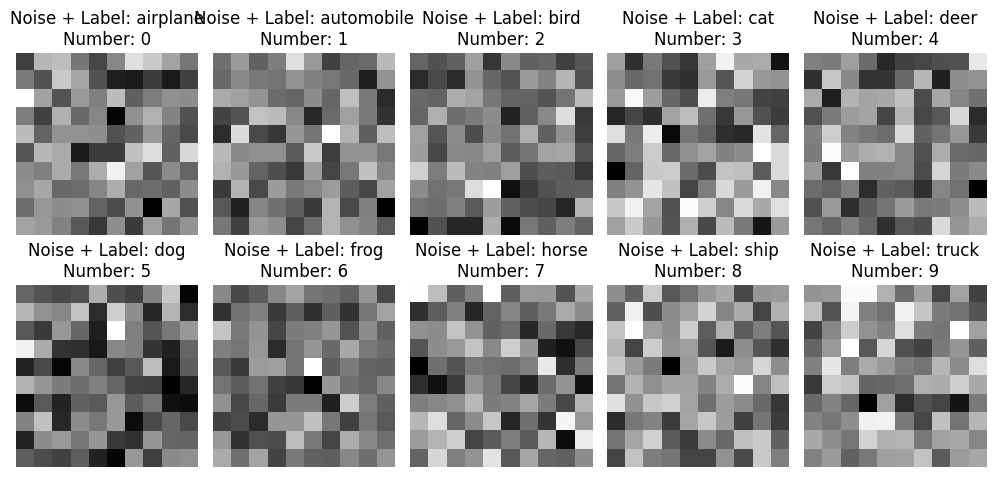

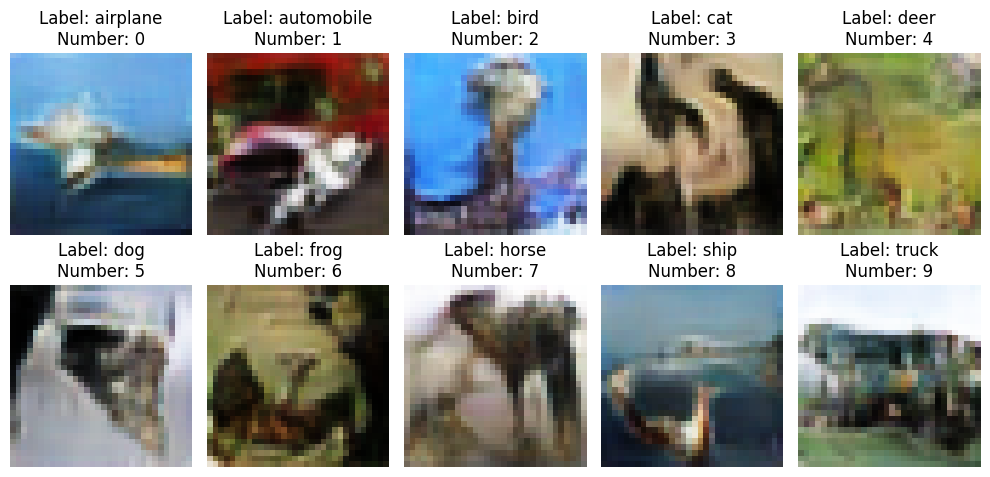

[Epoch 211/300] [C Loss: -0.0245] [G Loss: -0.0023]
[Epoch 212/300] [C Loss: 0.0017] [G Loss: 0.0030]
[Epoch 213/300] [C Loss: -0.0200] [G Loss: 0.0395]
[Epoch 214/300] [C Loss: 0.0020] [G Loss: -0.0003]
[Epoch 215/300] [C Loss: -0.0729] [G Loss: 0.0177]
[Epoch 216/300] [C Loss: -0.0074] [G Loss: 0.0161]
[Epoch 217/300] [C Loss: -0.0204] [G Loss: 0.0279]
[Epoch 218/300] [C Loss: -0.0568] [G Loss: 0.0269]
[Epoch 219/300] [C Loss: -0.0250] [G Loss: -0.0025]
[Epoch 220/300] [C Loss: -0.0083] [G Loss: 0.0293]
모델 가중치를 weight/GAN_epoch_220.pth에 저장했습니다.


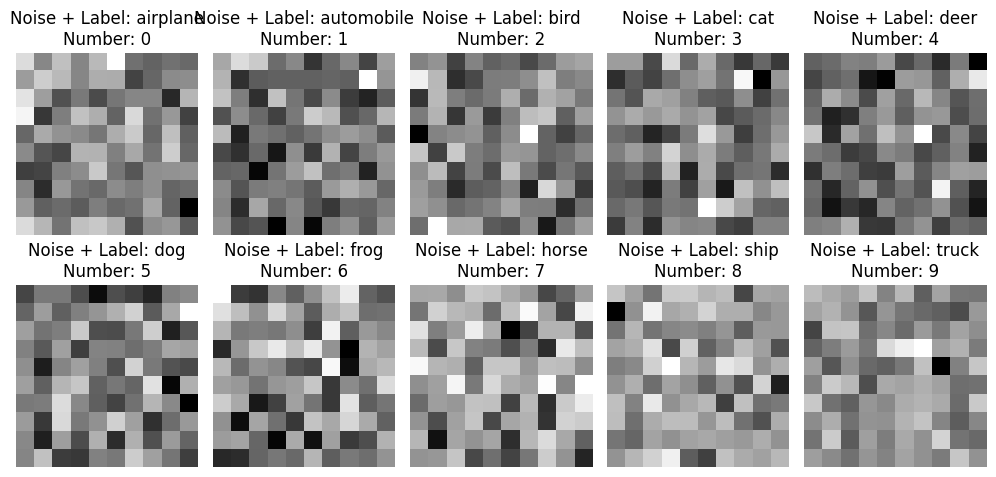

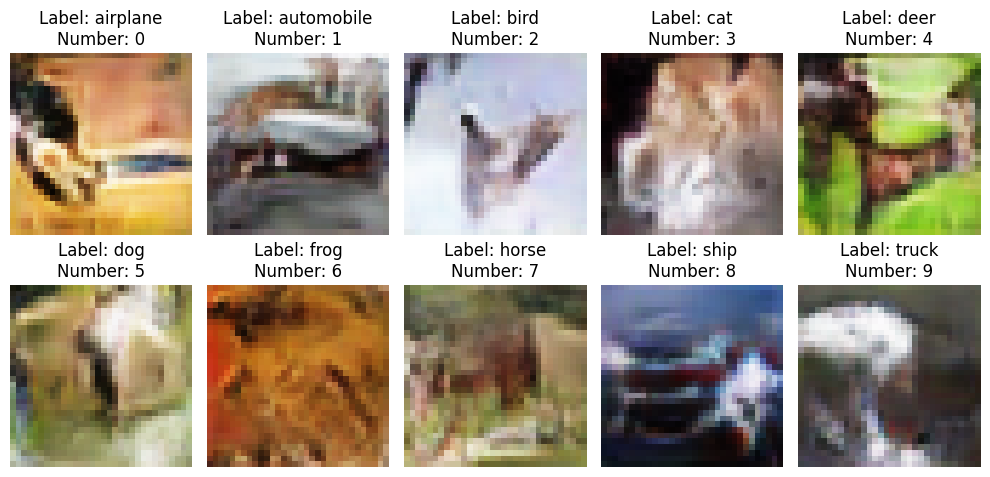

[Epoch 221/300] [C Loss: -0.0270] [G Loss: 0.0083]
[Epoch 222/300] [C Loss: -0.0688] [G Loss: -0.0064]
[Epoch 223/300] [C Loss: -0.0182] [G Loss: 0.0135]
[Epoch 224/300] [C Loss: -0.0004] [G Loss: 0.0468]
[Epoch 225/300] [C Loss: -0.0308] [G Loss: 0.0290]
[Epoch 226/300] [C Loss: -0.0479] [G Loss: 0.0420]


In [11]:

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 모델 초기화
generator = Generator(latent_dim, num_classes, img_size).to(device)
critic = Critic(num_classes, img_size).to(device)

# 최적화 함수 설정
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_C = optim.RMSprop(critic.parameters(), lr=lr)

# 데이터 로딩
dataloader = load_data(batch_size)

# 파일이 존재하면 가중치를 불러오고, 그렇지 않으면 첫 번째 epoch부터 학습 시작
if os.path.exists(path):
    # 저장된 모델의 가중치를 불러오기
    last_epoch = load_model_weights(generator, critic, path)
    start_epoch = last_epoch + 1 if last_epoch < num_epochs else num_epochs
    print(f"가중치 파일을 불러왔습니다. {start_epoch}번째 epoch부터 학습을 시작합니다.")
else:
    start_epoch = 1  # 가중치 파일이 없으면 첫 번째 epoch부터 시작
    print("가중치 파일이 존재하지 않으므로 첫 번째 epoch부터 학습을 시작합니다.")

# 훈련하기
train_model(generator, critic, dataloader, optimizer_G, optimizer_C, num_epochs, n_critic, clip_value, device, start_epoch)


# Inference

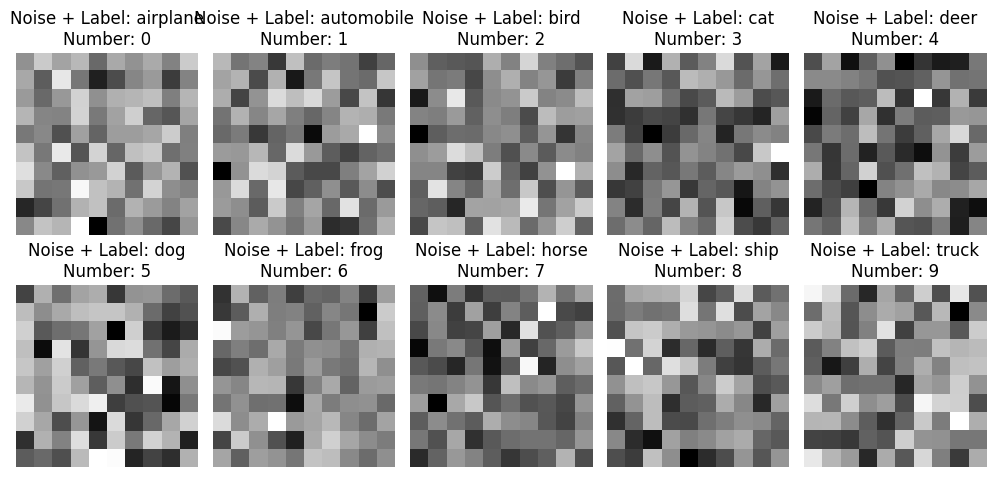

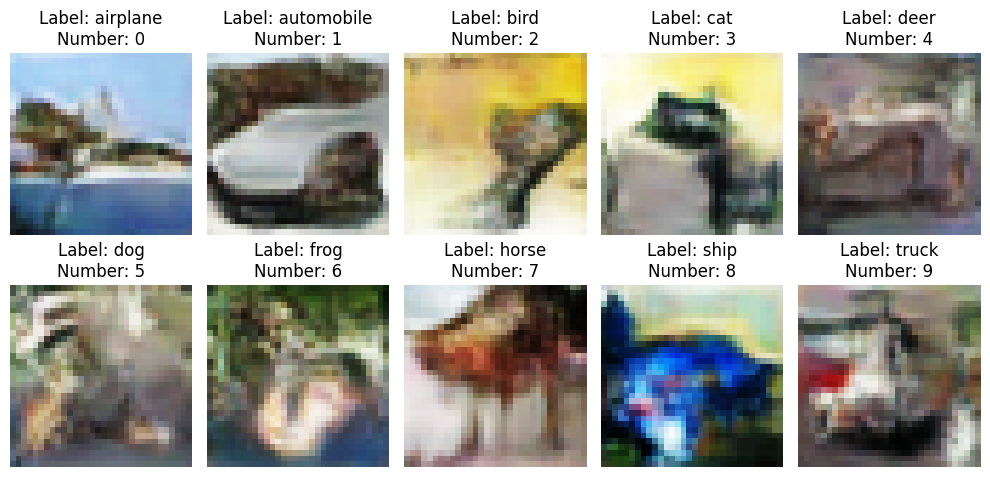

In [50]:
# 학습된 모델을 통해 노이즈 벡터와 생성된 이미지 시각화
show_noise_and_generated_images(generator)